In [1]:
import numpy as np
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, BatchNormalization, Lambda
from keras.layers.advanced_activations import ELU
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop

from keras import regularizers


import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

Load training and validation sets

In [4]:
genres_dict = {0: 'Electronic', 1: 'Experimental', 2: 'Folk', 3: 'Hip-Hop', 
               4: 'Instrumental', 5: 'International', 6: 'Pop', 7: 'Rock'}

train_npz = np.load('../data/downloaded_data/train.npz')
X_train = train_npz['arr_0']
y_train = train_npz['arr_1']
print(X_train.shape, y_train.shape)

(6394, 640, 128) (6394, 8)


In [5]:
valid_npz = np.load('../data/downloaded_data/valid.npz')

X_valid = valid_npz['arr_0']
y_valid = valid_npz['arr_1']
print(X_valid.shape, y_valid.shape)

(800, 640, 128) (800, 8)


Check the data translated back by building spectogram from data point

Experimental


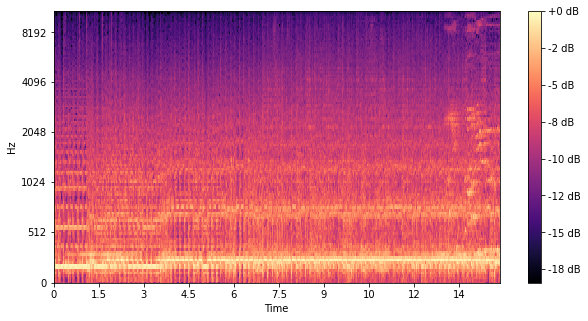

In [21]:
#Build spectogram

#Getting first instance of spectogram array and its corresponding genre
spectogram = X_train[5300]
genre = y_train[5300]

print(genres_dict[np.argmax(genre)])
plt.figure(figsize=(10, 5));
librosa.display.specshow(spectogram.T, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');


Creating CNN-RNN Model

In [22]:
batch_size = 32
num_classes = 8
n_features = X_train.shape[2]
n_time = X_train.shape[1]

#Model Parameters
N_LAYERS = 3
FILTER_LENGTH = 5
CONV_FILTER_COUNT = 56
BATCH_SIZE = 32
LSTM_COUNT = 96
EPOCH_COUNT = 70
NUM_HIDDEN = 64
L2_ratio = 0.001

In [23]:
def build_cnn_rnn_model():
    
    print('Building model...')
    model = Sequential()
    
    #CNN Layer
    model.add(Embedding(128, num_classes))
    model.add(Conv1D(CONV_FILTER_COUNT, 
                     kernel_size=FILTER_LENGTH, 
                     kernel_regularizer=regularizers.l2(L2_ratio),
                     padding='same',
                     activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.4))
    model.add(Conv1D(CONV_FILTER_COUNT, 
                     kernel_size=FILTER_LENGTH, 
                     kernel_regularizer=regularizers.l2(L2_ratio),
                     padding='same',
                     activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.4))
    model.add(Conv1D(CONV_FILTER_COUNT, 
                     kernel_size=FILTER_LENGTH, 
                     kernel_regularizer=regularizers.l2(L2_ratio),
                     padding='same',
                     activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.4))
    
    #LSTM (RNN) Layer
    model.add(LSTM(LSTM_COUNT, return_sequences=False))
    model.add(Dropout(0.4))
    
    #Dense Layer
    model.add(Dense(NUM_HIDDEN, kernel_regularizer=regularizers.l2(L2_ratio)))
    model.add(Dropout(0.4))
    
    #Softmax output for predicting genre categorical probability
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(lr=0.001), 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model
    
    
    

In [28]:
def train_model(model, X_train, y_train, X_val, y_val):
    
    n_features = X_train.shape[2]
    input_shape = (None, n_features)
    model_input = Input(input_shape, name='input')
    
    #Save when reaches max val_acc
    checkpoint_callback = ModelCheckpoint('weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
                verbose=1)
    
    callbacks_list = [checkpoint_callback, reducelr_callback]
    
    #Fit model
    print('Training...')
    history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, 
                        epochs=EPOCH_COUNT, validation_data=(X_val, y_val), 
                        verbose=1, callbacks=callbacks_list)
    
    return model, history

In [27]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
crnn = build_cnn_rnn_model()

model, history = train_model(crnn, X_train, y_train, X_val, y_val)

In [29]:
show_summary_stats(history)

NameError: name 'history' is not defined

In [35]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_valid, axis=1)
y_pred = model.predict(X_valid)
y_pred = np.argmax(y_pred, axis=1)

target_names = genres_dict.values()
print(classification_report(y_true, y_pred, target_names=target_names))

NameError: name 'model' is not defined

In [ ]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_true, y_pred))

